In [1]:
import numpy as np
import time
from PIL import Image

In [2]:
def load_obj(path):
    """ Reads a triangle mesh from obj file.
    
    Args:
        path: obj file containing triangular faces only.
        
    Returns:
        V: n-by-3 (float) matrix with vertex coordinates as rows.
        T: m-by-3 (int) matrix containing zero-based indices to columns of V.
            Each row of T specifies a triangle in counter-clockwise orientation.
    """
    V, T = [], []
    with open(path, "r") as f:
        for line in f:
            if line.startswith("v"):
                s = line.split()
                V.append(np.array([s[1], s[2], s[3]]))
            if line.startswith("f"):
                s = line.split()
                T.append(np.array([int(s[1]), int(s[2]), int(s[3])]) - 1) # obj indices start at 1

    # Convert lists of arrays to matrices
    return np.array(V, dtype=float), np.array(T, dtype=int)

In [3]:
def normalize_mesh(V):
    """ Translates center of gravity to origin
        and scales bounding sphere radius to 1.
        
    Returns:
        A new n-by-3 position matrix.
    """
    cog = np.mean(V, axis=0)
    radius = np.max(np.linalg.norm(V - cog, axis=1))
    
    return (V - cog) / radius

In [4]:
def normalize(v):
    return v / np.linalg.norm(v)

def triangle_normals(V, T):
    """ Computes outward-pointing normal for each triangle.
    
    Returns:
        N: m-by-3 matrix with per-triangle normals as rows.
    """
    N = np.zeros((T.shape[0], 3))
    for i in range(T.shape[0]):
        a, b, c = V[T[i]] # Unpack triangle vertices as 3d vectors
        N[i] = normalize(np.cross(b - a, c - a))
        
    return N

In [5]:
def view_matrix(cam_pos, view_dir):
    """ Assemble view matrix.
    
    The 4-by-4 view matrix transforms points (in homogeneous coordinates)
    from world space to camera space. Camera space is a right-handed
    coordinate system, with the camera in the origin and pointing in
    negative z-direction.
    
    Args:
        cam_pos: 3d camera position in world space.
        view_dir: 3d viewing direction in world space.
    """
    # Compute orthonormal frame
    world_up = np.array([0, 1, 0])
    d = normalize(view_dir)
    right = normalize(np.cross(view_dir, world_up))
    cam_up = normalize(np.cross(right, view_dir))
    
    # Move to origin
    T = np.identity(4)
    T[0:3, 3] = -cam_pos
    
    # Rotate -d to positive z-axis.
    R = np.identity(4)
    R[0:3, 0] = right
    R[0:3, 1] = cam_up
    R[0:3, 2] = -d
    
    return R.T @ T

def projection_matrix(fov_deg, aspect_ratio, near, far):
    """ Assemble projection matrix (aka frustum matrix).
    
    The 4-by-4 projection matrix transforms the viewing frustum (defined
    by near/far plane and opening angle in camera space) to the unit cube.
    
    This transformation reverses the z-axis, i.e. it maps [-near, -far]
    to [-1, 1]. The resulting coordinate system (normalized device coordinates)
    is left-handed!
    
    Args:
        fov_deg: Field-of-view (opening angle) in degrees.
        aspect_ratio: Screen width / height.
        near: Near plane distance from origin in camera space. Positive number.
        far: Far plane distance from origin in camera space. Positive number.
    """
    # Assume a symmetric frustum
    fov_rad = fov_deg * np.pi / 180.
    top = near * np.tan(fov_rad / 2.)
    right = top * aspect_ratio
    
    # A derivation of this matrix can be found at
    # http://www.songho.ca/opengl/gl_projectionmatrix.html.
    P = np.zeros((4, 4))
    P[0, 0] = near / right
    P[1, 1] = near / top
    P[2, 2] = -(far + near) / (far - near)
    P[2, 3] = -2. * far * near / (far - near)
    P[3, 2] = -1.
    
    return P

In [6]:
def dehomogenize(V):
    """ Dehomogenize points in homogeneous coordinates by
        deviding by the last component.
    
    Args:
        V: n-by-d matrix with d >= 2.
        
    Returns:
        n-by-(d-1) matrix.
    """
    return V[:, 0:-1] / np.array([V[:, -1]]).T

def transform_vertices(V, N, MV, P):
    """ This is the vertex shader. It transforms vertices (and normals)
        from model space to (1) camera space and (2) normalized device
        coordinates.
        
    Args:
        V: n-by-3 matrix with vertex positions as rows.
        N: m-by-3 matrix with normals as rows.
        MV: 4-by-4 model-view matrix (object to camera space).
        P: 4-by-4 projection matrix (camera space to ndc).

    Returns:
        V_cam: n-by-3 matrix with vertices in camera space.
        N_cam: n-by-3 matrix with normals in camera space.
        V_ndc_hom: n-by-4 matrix with vertices in ndc (hom. coordinates).
    """
    # Switch to 4d homogeneous coordinates.
    V_hom = np.append(V, np.ones((V.shape[0], 1)), axis=1)
    
    # Compute vertex positions in camera space.
    # (Multiply from right because our vertices are row vectors.)
    V_cam_hom = V_hom @ MV.T
    V_cam = dehomogenize(V_cam_hom)

    # Compute normals in camera space.
    # Set up 3-by-3 normal matrix using only the linear part of MV.
    normal_transform = np.linalg.inv(MV[0:3, 0:3]).T
    N_cam = N @ normal_transform.T
    
    # Compute vertex positions in normalized device coordinates.
    V_ndc_hom = V_cam_hom @ P.T
    
    return V_cam, N_cam, V_ndc_hom

In [7]:
def backfacing(tri_points):
    """ True iff the 2d triangle is backfacing in a left-handed coordinate system.
    
    Args:
        tri_points: 3-by-2 matrix defining a 2d triangle.
    """
    a, b, c = tri_points # Unpack triangle vertices as 3d vectors.
    
    # Check derminant (aka 2d cross product) of a triangle sector.
    # Backfacing iff det > 0 in a left-handed coordinate system.
    return np.linalg.det(np.concatenate(([b - a], [c - a]))) > 0

def bounding_box(points, w, h):
    """ Computes bounding box of 2d points and clips it w.r.t. screen dimensions.
    
    Args:
        points: k-by-2 matrix with 2d points.
        w, h: maximum x, y coordinates. Result is clipped between [0, 0] and [w, h] (exclusive).
        
    Returns:
        bbmin, bbmax: top-left and bottom-right corner of the bounding box.
    """
    bbmin = np.floor(np.min(points, axis=0)).astype('int')
    bbmax = np.ceil(np.max(points, axis=0)).astype('int')
    bbmin = np.clip(bbmin, [0, 0], [w - 1, h - 1])
    bbmax = np.clip(bbmax, [0, 0], [w - 1, h - 1])    
    
    return bbmin, bbmax

def point_in_triangle(p, tri_points):
    """ True iff the 2d point is indide the triangle (edges inclusive).
        Assumes a left-handed coordinate system.
    
    Args:
        p: 2d point.
        tri_points: 3-by-2 matrix defining a 2d triangle.
    """
    for i in range(3):
        # Compute inward-pointing 2d normal of edge.
        # Does not have to be normalized.
        edge = tri_points[(i + 1) % 3] - tri_points[i]
        n = np.array([edge[1], -edge[0]]) # Rotate clockwise (left-handed).
        
        # The point is outside if it lies on the wrong side of this edge
        if np.dot(n, p - tri_points[i]) < 0:
            return False
        
    return True

def barycentric_coordinates(p, tri_points):
    """ Computes the barycentric coordinates of a 2d point in a triangle.
    
    Args:
        p: 2d point.
        tri_points: 3-by-2 matrix defining a 2d triangle.
        
    Returns:
        alpha, beta, gamma: with alpha + beta + gamma = 1.
    """
    a, b, c = tri_points # Unpack triangle vertices as 3d vectors.
    
    # Solve 2-by-2 linear system using Cramer's rule.
    denom = np.linalg.det(np.array([a - c, b - c]))
    alpha = np.linalg.det(np.array([p - c, b - c])) / denom
    beta = np.linalg.det(np.array([a - c, p - c])) / denom
    
    return alpha, beta, 1. - alpha - beta

def interpolate_perspectively(x, y, tri_points, tri_ndc_w, tri_values):
    """ Interpolates per-vertex data inside a triangle. The interpolation
        is linear in camera space (and thus also in world and object space).
        As both the triangle and the point in question are given in screen space,
        the perspective projection has to be "undone".
        
    Args:
        x, y: Screen space coordinates of interpolation point p.
        tri_points: 3-by-2 matrix defining the triangle in screen space.
        tri_ndc_w: 3-by-1 matrix containing the vertices' homogeneous components.
        tri_values: 3-by-k matrix containing the values to be interpolated.
        
    Returns:
        The interpolated value (a vector of size k).
    """
    alpha, beta, gamma = barycentric_coordinates(np.array([x, y]), tri_points)
    
    # See https://www.khronos.org/registry/OpenGL/specs/gl/glspec44.core.pdf, page 427.
    denom = alpha / tri_ndc_w[0] + beta / tri_ndc_w[1] + gamma / tri_ndc_w[2]
    value = np.sum(np.array([alpha, beta, gamma]) * tri_values / tri_ndc_w) / denom

    return value

In [8]:
def shade_fragment(x, y, n_cam, screen):
    """ This is the fragment shader. It assigns a color to the
        specified fragment/pixel on the screen.
        
    Args:
        x, y: Pixel coordinates in screen space (integer).
        n_cam: (Interpolated) normal in camera space.
        screen: w-by-h-by-3 matrix with per-pixel rgb values in [0, 255].
        
    Returns:
        None. Modifies the screen matrix.
    """
    # Use fixed colors and light emitted from camera.
    light_dir = np.array([0, 0, 1])
    ambient = np.array([32, 0, 16])
    diffuse_color = np.array([255, 0, 128]) * (1. - np.max(ambient)/255)
    
    # Simple Lambertian lighting.
    diffuse = np.dot(n_cam, light_dir)
    
    # Activate to render normals:
    #screen[x, y] = (n_cam + 1.) * 255. / 2.
    screen[x, y] = np.clip(diffuse_color * diffuse + ambient, 0, 255)

In [9]:
def rasterize_and_shade(V_screen, V_ndc_w, V_depth, T, N_cam, screen, depth):
    """ (1) Creates fragments by rasterizing all visible triangles.
        (2) Performs depth test.
        (3) Calls fragment shader for visible fragments only.
        
    Args:
        V_screen: n-by-2 matrix with screens space vertex positions.
        V_ndc_w: n-by-1 matrix containing the w component of vertices in ndc.
        V_depth: n-by-1 matrix containing the depth value of each vertex in ndc.
            Near plane: -1, far plane: 1.
        T: m-by-3 triangle matrix with triplets of indices into V as rows.
        N_cam: m-by-3 matrix with per-triangle normals in camera space.
        screen: w-by-h-by-3 array with rgb value per pixel.
        depth: w-by-h depth buffer, initialized with 1 (far).
        
    Returns:
        screen: Modifies input array.
    """
    w, h = screen.shape[0], screen.shape[1]
    
    for i, t in enumerate(T):
        # t is an index triple. t = v0, v1, v2.
        # Get screen space positions of triangle vertices (3x2 matrix).
        tri_points = V_screen[t]
        
        if backfacing(tri_points):
            continue

        # Enumerate fragments within bounding box.
        bbmin, bbmax = bounding_box(tri_points, w, h)
        for x in range(bbmin[0], bbmax[0] + 1):
            for y in range(bbmin[1], bbmax[1] + 1):
                if point_in_triangle([x, y], tri_points):

                    # Compute depth at fragment center (hence the 0.5).
                    d = interpolate_perspectively(x + 0.5, y + 0.5, tri_points, V_ndc_w[t], V_depth[t])
                    
                    # Clip vs near/far plane and perform depth test.
                    if d >= -1 and d <= 1 and d < depth[x, y]:
                        depth[x, y] = d
                        shade_fragment(x, y, N_cam[i], screen)
                    
    return screen

In [10]:
def render(V, T, N, cam_pos, loot_at, screen, depth):
    """ Render the given object into the screen array.
    
    Args:
        V: n-by-3 matrix with object space vertex positions as rows.
        T: m-by-3 triangle matrix with triplets of indices into V as rows.
        cam_pos: Camera position in world space.
        look_at: Point the camera is directed to in world space.
        screen: w-by-h-3 rgb array.
        depth: w-by-h depth buffer.
        
    Returns:
        screen: Modifies input array.
    """
    w, h = screen.shape[0], screen.shape[1]
    
    # Get model-view and projection matrix.
    MV = view_matrix(cam_pos=cam_pos, view_dir=loot_at-cam_pos)
    P = projection_matrix(fov_deg=90, aspect_ratio=w/h, near=0.01, far=100.)
    
    # Transform vertices.
    V_cam, N_cam, V_ndc_hom = transform_vertices(V, N, MV, P)
    
    # Dehomogenize coordinates and store depth coordinate separately.
    # The homogeneous is kept to be used in perspectively correct interpolation.
    V_ndc_w = V_ndc_hom[:, 3]
    V_ndc = dehomogenize(V_ndc_hom)
    V_depth = V_ndc[:, 2]
    
    # Viewport transormation: scale ndc to screen and move origin to top left.
    V_screen = V_ndc[:, 0:2] * np.array([w / 2., -h / 2.]) + np.array([w / 2., h / 2.])
    
    # Rasterize and immediately shade fragments.
    screen = rasterize_and_shade(V_screen, V_ndc_w, V_depth, T, N_cam, screen, depth)

    # Activate to render depth buffer:
    #return ((np.dstack((depth, depth, depth)) + 1.) * 127).astype('uint8')
    
    return screen

In [11]:
def test():
    # Init screen and depth buffer
    height = 480
    width = height * 16 // 9
    screen = np.zeros((width, height, 3), dtype=np.uint8)
    screen[:] = np.array([64, 64, 64], dtype=np.uint8)
    depth = np.ones((width, height))
    
    # Init camera
    cam_pos = np.array([0., 0.4, 1.])
    look_at = np.array([0., 0.075, 0.])

    # Load mesh
    #V, T = load_obj("meshes/bunny-low.obj")
    V, T = load_obj("meshes/bunny.obj")
    V = normalize_mesh(V)
    N = triangle_normals(V, T)
    
    # Render
    #start = time.time()
    screen = render(V, T, N, cam_pos, look_at, screen, depth)
    #seconds = time.time() - start
    #print("Render took %f seconds." % seconds)

    return screen

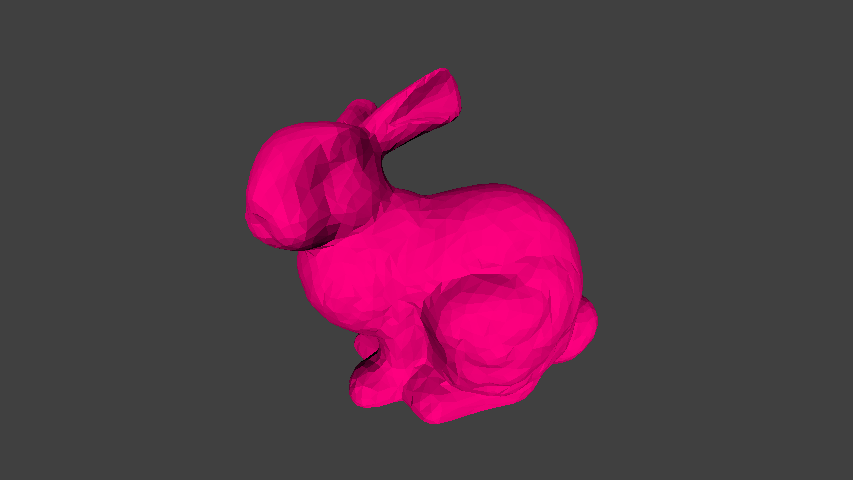

In [12]:
Image.fromarray(np.transpose(test(), (1, 0, 2))) # Transpose axes (x, y) -> (y, x)